# KNN Regression Data (NO₂ Medan)

**K-Nearest Neighbors (KNN) Regression** merupakan salah satu metode *machine learning* berbasis jarak yang digunakan untuk melakukan prediksi nilai kontinu.  
Prinsip utama KNN Regression adalah melakukan estimasi nilai target berdasarkan **kedekatan data baru** dengan beberapa data historis yang memiliki karakteristik serupa (*nearest neighbors*).  

Pada saat proses prediksi, algoritma akan:  
1. Menghitung jarak antara data baru dengan seluruh data historis (menggunakan metrik seperti Euclidean Distance).  
2. Memilih **K tetangga terdekat (nearest neighbors)** berdasarkan jarak terkecil.  
3. Mengambil **rata-rata nilai target** dari tetangga terdekat tersebut sebagai hasil prediksi.


## Penerapan pada Prediksi NO₂ Kota Medan

Dalam konteks kasus **prediksi konsentrasi Nitrogen Dioksida (NO₂)**, nilai *lag* (misalnya NO₂ dua hingga lima hari sebelumnya) digunakan sebagai **fitur masukan (features)**.  
Fitur-fitur ini merepresentasikan kondisi historis dari konsentrasi NO₂.  

KNN kemudian akan mencari periode masa lalu yang memiliki pola *lag* serupa, kemudian memprediksi **kadar NO₂ untuk hari berikutnya** berdasarkan **rata-rata kadar NO₂ dari periode-periode yang mirip tersebut**.

Pendekatan ini cocok untuk data deret waktu yang memiliki pola perubahan tidak terlalu tajam, karena KNN mengandalkan kesamaan pola data sebelumnya untuk memperkirakan nilai di masa depan.


## Mengapa Nilai R² dan MSE Rendah pada Eksperimen?

Nilai **R-Squared (R²)** yang rendah menunjukkan bahwa model belum mampu menjelaskan variasi kadar NO₂ dengan baik.  
Hal ini wajar karena model hanya menggunakan data *lag* (2–5 hari sebelumnya) sebagai prediktor, tanpa memasukkan **variabel lingkungan lain** seperti:

- Suhu udara  
- Kelembapan  
- Curah hujan  
- Arah dan kecepatan angin  
- Aktivitas lalu lintas atau industri  

Faktor-faktor tersebut memiliki pengaruh besar terhadap fluktuasi kadar NO₂ di atmosfer.  
Akibatnya, KNN hanya dapat "menebak" pola berdasarkan kemiripan historis dari satu variabel (NO₂), sehingga performa model menjadi terbatas.


## Modeling Data NO₂ Medan

Proses modeling dilakukan berdasarkan hasil eksperimen pada tahap konversi *supervised learning* dengan jumlah *lag* berbeda.  
Tujuannya adalah membandingkan seberapa besar pengaruh jumlah *lag features* terhadap performa model KNN Regression.

### Tahapan Modeling:
1. **Import Library**  
   Mengimpor pustaka yang dibutuhkan seperti `pandas`, `numpy`, `sklearn`, dan `matplotlib`.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import joblib
import os


2. **Membaca Dokumen**  
   Membaca dataset hasil konversi *supervised* (lag 2–5 hari) yang telah disimpan dalam format CSV.



In [ ]:
day1 = pd.read_csv('no2_results/day1_supervised.csv')
day2 = pd.read_csv('no2_results/day2_supervised.csv')
day3 = pd.read_csv('no2_results/day3_supervised.csv')
day4 = pd.read_csv('no2_results/day4_supervised.csv')
day5 = pd.read_csv('no2_results/day5_supervised.csv')

3. **Modelling**  

## **Definisikan Batas Ambang (Threshold) dan Buat Labels**


DEFINISIKAN THRESHOLD DAN BUAT LABELS

Definisi Threshold:
  - Menggunakan: 75th percentile dari day1_supervised.csv
  - Nilai threshold: 0.00003806 mol/m²

  - Label 0 (AMAN):      NO2 ≤ 0.00003806
  - Label 1 (BERBAHAYA): NO2 > 0.00003806

Distribusi Label (untuk evaluasi threshold):
  - Label 0 (AMAN):      296 samples (74.9%)
  - Label 1 (BERBAHAYA): 99 samples (25.1%)


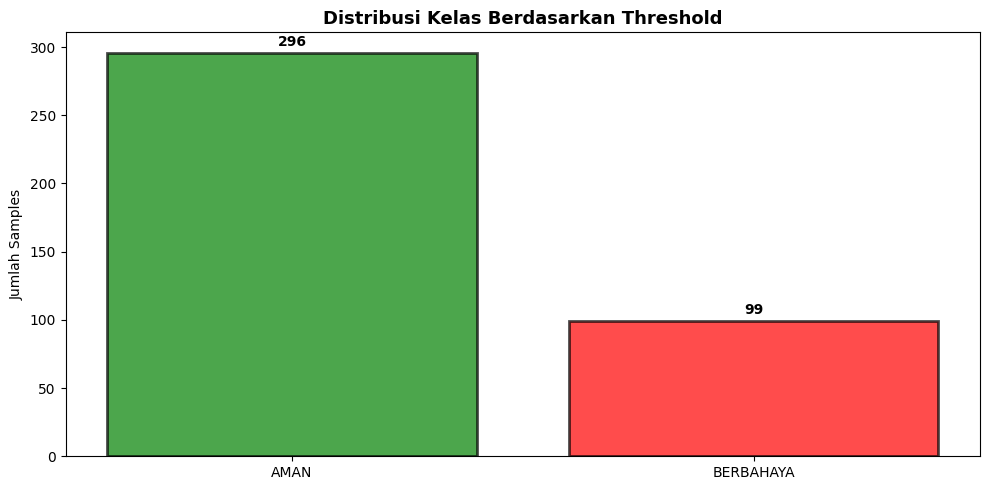


Threshold berhasil didefinisikan
CATATAN: Model akan memprediksi nilai NO2 (regression), lalu threshold diterapkan


In [ ]:
print("\n" + "="*70)
print("DEFINISIKAN THRESHOLD DAN BUAT LABELS")
print("="*70)

# Gunakan 75th percentile sebagai threshold dari day1_supervised.csv
try:
    day1_for_threshold = pd.read_csv('no2_results/day1_supervised.csv')
    # Assuming 'NO2' column in day1_supervised is the target (NO2(t))
    threshold = day1_for_threshold["NO2"].quantile(0.75)

    print(f"\nDefinisi Threshold:")
    print(f"  - Menggunakan: 75th percentile dari day1_supervised.csv")
    print(f"  - Nilai threshold: {threshold:.8f} mol/m²")
    print(f"\n  - Label 0 (AMAN):      NO2 ≤ {threshold:.8f}")
    print(f"  - Label 1 (BERBAHAYA): NO2 > {threshold:.8f}")

    # Buat binary labels untuk evaluasi nanti (setelah regression)
    # Gunakan data dari day1_supervised.csv untuk membuat labels
    binary_labels = (day1_for_threshold["NO2"] > threshold).astype(int)


    # Statistik label
    print(f"\nDistribusi Label (untuk evaluasi threshold):")
    label_counts = binary_labels.value_counts().sort_index()
    # Ensure both labels exist in label_counts for printing and plotting
    label_0_count = label_counts.get(0, 0)
    label_1_count = label_counts.get(1, 0)

    print(f"  - Label 0 (AMAN):      {label_0_count} samples ({label_0_count/len(binary_labels)*100:.1f}%)")
    print(f"  - Label 1 (BERBAHAYA): {label_1_count} samples ({label_1_count/len(binary_labels)*100:.1f}%)")

    # Visualisasi class distribution
    fig, ax = plt.subplots(figsize=(10, 5))
    labels_text = ['AMAN', 'BERBAHAYA']
    colors_bar = ['green', 'red']
    # Use the retrieved counts for plotting
    plot_counts = [label_0_count, label_1_count]
    ax.bar(labels_text, plot_counts, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
    ax.set_title('Distribusi Kelas Berdasarkan Threshold', fontsize=13, fontweight='bold')
    ax.set_ylabel('Jumlah Samples')
    for i, v in enumerate(plot_counts):
        ax.text(i, v + 5, str(v), ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"\nThreshold berhasil didefinisikan")
    print(f"CATATAN: Model akan memprediksi nilai NO2 (regression), lalu threshold diterapkan")

except FileNotFoundError:
    print("\n[ERROR] File day1_supervised.csv tidak ditemukan.")
    print("Tidak dapat mendefinisikan threshold.")
    # Set threshold to None or a default value if file not found
    threshold = None
    print("\nThreshold tidak didefinisikan.")

except KeyError:
    print(f"\n[ERROR] Kolom 'NO2' tidak ditemukan di day1_supervised.csv.")
    print("Pastikan day1_supervised.csv memiliki kolom 'NO2'.")
    threshold = None
    print("\nThreshold tidak didefinisikan.")

In [ ]:
X = day1.drop(columns=['NO2'])
y = day1['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=12)
knn.fit(X_train_scaled, y_train)
day1_predict = knn.predict(X_test_scaled)
r2_day1 = r2_score(y_test, day1_predict)
mse_day1 = mean_squared_error(y_test, day1_predict)
mae_day1 = mean_absolute_error(y_test, day1_predict)
mape_day1 = mean_absolute_percentage_error(y_test, day1_predict)

print("MSE:", mse_day1)
print("MAE:", mae_day1)
print("R2:", r2_day1)
print(f"MAPE: {mape_day1 * 100:.2f}%")

joblib.dump(knn, 'saved_models/knn_model_day1.pkl')
joblib.dump(scaler, 'saved_models/scaler_day1.pkl')

MSE: 8.741734765981554e-11
MAE: 7.38364597554012e-06
R2: 0.2065806928532351
MAPE: 26.33%


['saved_models/scaler_day1.pkl']

In [ ]:
X = day2.drop(columns=['NO2'])
y = day2['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=12)
knn.fit(X_train_scaled, y_train)
day2_predict = knn.predict(X_test_scaled)
r2_day2 = r2_score(y_test, day2_predict)
mse_day2 = mean_squared_error(y_test, day2_predict)
mae_day2 = mean_absolute_error(y_test, day2_predict)
mape_day2 = mean_absolute_percentage_error(y_test, day2_predict)

print("MSE:", mse_day2)
print("MAE:", mae_day2)
print("R2:", r2_day2)
print(f"MAPE: {mape_day2 * 100:.2f}%")

joblib.dump(knn, 'saved_models/knn_model_day2.pkl')
joblib.dump(scaler, 'saved_models/scaler_day2.pkl')

MSE: 1.1641574264470848e-10
MAE: 8.093202888997373e-06
R2: 0.10352771500919755
MAPE: 52.36%


['saved_models/scaler_day2.pkl']

In [ ]:
X = day3.drop(columns=['NO2'])
y = day3['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=12)
knn.fit(X_train_scaled, y_train)
day3_predict = knn.predict(X_test_scaled)
r2_day3 = r2_score(y_test, day3_predict)
mse_day3 = mean_squared_error(y_test, day3_predict)
mae_day3 = mean_absolute_error(y_test, day3_predict)
mape_day3 = mean_absolute_percentage_error(y_test, day3_predict)

print("MSE:", mse_day3)
print("MAE:", mae_day3)
print("R2:", r2_day3)
print(f"MAPE: {mape_day3 * 100:.2f}%")

joblib.dump(knn, 'saved_models/knn_model_day3.pkl')
joblib.dump(scaler, 'saved_models/scaler_day3.pkl')

MSE: 7.571730142514304e-11
MAE: 6.77846775387606e-06
R2: 0.2671736899179844
MAPE: 51.65%


['saved_models/scaler_day3.pkl']

In [ ]:
X = day4.drop(columns=['NO2'])
y = day4['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=12)
knn.fit(X_train_scaled, y_train)
day4_predict = knn.predict(X_test_scaled)
r2_day4 = r2_score(y_test, day4_predict)
mse_day4 = mean_squared_error(y_test, day4_predict)
mae_day4 = mean_absolute_error(y_test, day4_predict)
mape_day4 = mean_absolute_percentage_error(y_test, day4_predict)

print("MSE:", mse_day4)
print("MAE:", mae_day4)
print("R2:", r2_day4)
print(f"MAPE: {mape_day4 * 100:.2f}%")

joblib.dump(knn, 'saved_models/knn_model_day4.pkl')
joblib.dump(scaler, 'saved_models/scaler_day4.pkl')

MSE: 8.013404373962427e-11
MAE: 6.854367786574172e-06
R2: 0.12462552445345898
MAPE: 25.43%


['saved_models/scaler_day4.pkl']

In [ ]:
X = day5.drop(columns=['NO2'])
y = day5['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=12)
knn.fit(X_train_scaled, y_train)
day5_predict = knn.predict(X_test_scaled)
r2_day5 = r2_score(y_test, day5_predict)
mse_day5 = mean_squared_error(y_test, day5_predict)
mae_day5 = mean_absolute_error(y_test, day5_predict)
mape_day5 = mean_absolute_percentage_error(y_test, day5_predict)

print("MSE:", mse_day5)
print("MAE:", mae_day5)
print("R2:", r2_day5)
print(f"MAPE: {mape_day5 * 100:.2f}%")

joblib.dump(knn, 'saved_models/knn_model_day5.pkl')
joblib.dump(scaler, 'saved_models/scaler_day5.pkl')

MSE: 6.985561952526327e-11
MAE: 6.4370416922265665e-06
R2: 0.1388936252749925
MAPE: 24.11%


['saved_models/scaler_day5.pkl']

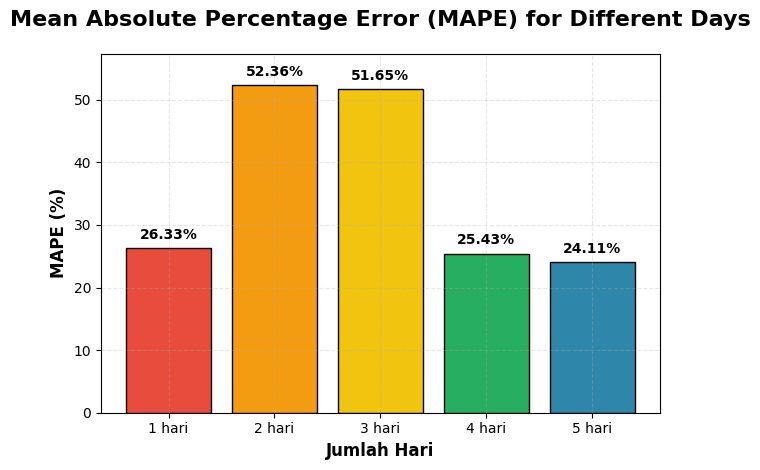

In [ ]:
import matplotlib.pyplot as plt

x = ['1 hari', '2 hari', '3 hari', '4 hari', '5 hari']
y = [mape_day1 * 100, mape_day2 * 100, mape_day3 * 100, mape_day4 * 100, mape_day5 * 100]

colors = ['#E74C3C', '#F39C12', '#F1C40F', '#27AE60', '#2E86AB']
bars = plt.bar(x, y, color=colors, edgecolor='black', linewidth=1)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{y[i]:.2f}%', ha='center', va='bottom',
             fontweight='bold', fontsize=10)

plt.title('Mean Absolute Percentage Error (MAPE) for Different Days', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Jumlah Hari', fontsize=12, fontweight='bold')
plt.ylabel('MAPE (%)', fontsize=12, fontweight='bold')
plt.ylim(0, max(y) + 5)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

## **Prediksi Nilai NO2 Satu Hari Ke Depan**


LANGKAH 9: PREDIKSI NILAI NO2 SATU HARI KE DEPAN

Menggunakan nilai 't-1' terakhir dari day1_supervised.csv sebagai input.
  - Nilai input (NO2(t-1)): 0.00003859 mol/m²

Scaler dan model day1 berhasil dimuat.

Data hari ini (Ternormalisasi dengan scaler day1):
  - NO2(t-1): 0.5579

HASIL PREDIKSI NO2 HARI BESOK (SATU HARI KE DEPAN)

[A] PREDIKSI NILAI NO2 (Regresi):
  - NO2 Prediksi: 0.00003236 mol/m²

[B] PENERAPAN THRESHOLD:
  - Threshold: 0.00003806 mol/m²
  - Status: AMAN
  - Selisih: -0.00000570 mol/m²
  - Persentase: -14.99% dari threshold

✓ AMAN: NO2 diprediksi 15.0% di bawah threshold
   → Kualitas udara dalam batas aman


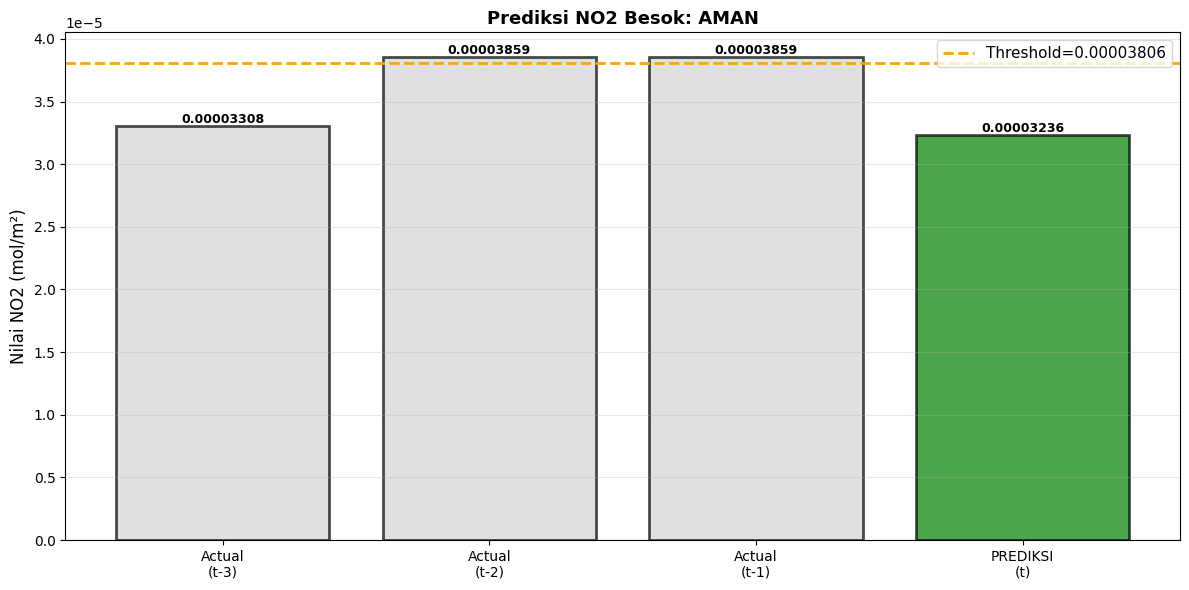

In [ ]:
print("\n" + "="*70)
print("LANGKAH 9: PREDIKSI NILAI NO2 SATU HARI KE DEPAN")
print("="*70)

# Definisikan threshold (pastikan sel sebelumnya sudah dijalankan untuk mendefinisikan threshold)
if 'threshold' not in locals() and 'threshold' not in globals():
     print("\n[INFO] Variabel 'threshold' belum didefinisikan.")
     print("Mencoba memuat threshold dari day1_supervised.csv...")
     try:
         day1_for_threshold = pd.read_csv('no2_results/day1_supervised.csv')
         threshold = day1_for_threshold["NO2"].quantile(0.75)
         print(f"  - Threshold dimuat: {threshold:.8f} mol/m²")
     except Exception as e:
         print(f"\n[ERROR] Gagal memuat threshold: {e}")
         print("Menggunakan nilai threshold default.")
         threshold = 0.00005 # Default fallback value


# Ambil nilai NO2(t-1) dari baris terakhir day1_supervised.csv
# Karena model day1 menggunakan lag 1 (NO2(t-1)) untuk memprediksi NO2(t)
# Kita perlu nilai NO2(t-1) dari baris terakhir day1 untuk memprediksi NO2(t) (besok)
try:
    last_day_original = day1['t-1'].iloc[-1]
    print("\nMenggunakan nilai 't-1' terakhir dari day1_supervised.csv sebagai input.")
    print(f"  - Nilai input (NO2(t-1)): {last_day_original:.8f} mol/m²")

except KeyError:
     print("\n[ERROR] Kolom 't-1' tidak ditemukan di day1_supervised.csv.")
     print("Pastikan day1_supervised.csv memiliki kolom 't-1'.")
     last_day_original = None


if last_day_original is not None:
    # Load scaler dan model yang sesuai dengan day1
    try:
        knn_model_day1 = joblib.load('saved_models/knn_model_day1.pkl')
        scaler_day1 = joblib.load('saved_models/scaler_day1.pkl')
        print("\nScaler dan model day1 berhasil dimuat.")
    except FileNotFoundError:
        print("\n[ERROR] File model atau scaler day1 tidak ditemukan.")
        print("Pastikan model dan scaler untuk day1 sudah disimpan.")
        knn_model_day1 = None # Set to None to prevent errors later
        scaler_day1 = None


    if knn_model_day1 and scaler_day1:
        # Normalisasi menggunakan parameter dari scaler day1
        # Input untuk scaler harus dalam bentuk 2D array/dataframe
        # Convert to DataFrame with correct feature name before scaling
        last_day_original_df = pd.DataFrame([[last_day_original]], columns=['t-1'])
        last_day_scaled = scaler_day1.transform(last_day_original_df)[0]


        print(f"\nData hari ini (Ternormalisasi dengan scaler day1):")
        print(f"  - NO2(t-1): {last_day_scaled[0]:.4f}")

        # Reshape untuk input model (model day1 expects 1 feature)
        X_tomorrow = last_day_scaled.reshape(1, -1)

        # Prediksi nilai NO2 (regresi) menggunakan model day1
        pred_no2_value = knn_model_day1.predict(X_tomorrow)[0]

        # Terapkan threshold (gunakan threshold yang sama seperti sebelumnya jika sudah didefinisikan)
        # Pastikan variabel 'threshold' sudah didefinisikan di sel sebelumnya
        if 'threshold' in locals() or 'threshold' in globals():
            pred_status = 'BERBAHAYA' if pred_no2_value > threshold else 'AMAN'
            difference_from_threshold = pred_no2_value - threshold
            percentage_diff = (difference_from_threshold / threshold) * 100

            print("\n" + "="*70)
            print("HASIL PREDIKSI NO2 HARI BESOK (SATU HARI KE DEPAN)")
            print("="*70)
            print(f"\n[A] PREDIKSI NILAI NO2 (Regresi):")
            print(f"  - NO2 Prediksi: {pred_no2_value:.8f} mol/m²")

            print(f"\n[B] PENERAPAN THRESHOLD:")
            print(f"  - Threshold: {threshold:.8f} mol/m²")
            print(f"  - Status: {pred_status}")
            print(f"  - Selisih: {difference_from_threshold:.8f} mol/m²")
            print(f"  - Persentase: {percentage_diff:+.2f}% dari threshold")

            if pred_status == 'BERBAHAYA':
                if percentage_diff > 20:
                    print(f"\n⚠ PERINGATAN TINGGI: NO2 diprediksi {percentage_diff:.1f}% DI ATAS threshold!")
                    print(f"   → Prediksi SANGAT BERBAHAYA, ambil tindakan pencegahan!")
                elif percentage_diff > 10:
                    print(f"\n⚠ PERINGATAN SEDANG: NO2 diprediksi {percentage_diff:.1f}% di atas threshold")
                    print(f"   → Status BERBAHAYA, waspadai kualitas udara!")
                else:
                    print(f"\n⚠ PERINGATAN: NO2 diprediksi {percentage_diff:.1f}% di atas threshold")
                    print(f"   → Status BERBAHAYA, perlu monitoring!")
            else:
                if abs(percentage_diff) < 5:
                    print(f"\n✓ HATI-HATI: NO2 diprediksi hanya {abs(percentage_diff):.1f}% DI BAWAH threshold")
                    print(f"   → Status masih AMAN, tapi mendekati batas ambang!")
                else:
                    print(f"\n✓ AMAN: NO2 diprediksi {abs(percentage_diff):.1f}% di bawah threshold")
                    print(f"   → Kualitas udara dalam batas aman")

            # Visualisasi prediksi dan data terakhir (t-3, t-2, t-1, Prediksi t)
            fig, ax = plt.subplots(figsize=(12, 6))

            # Ambil 3 data aktual terakhir sebelum input t-1
            # Ini memerlukan akses ke data asli sebelum supervised learning.
            # Jika data asli tidak tersedia, kita bisa mencoba mengambil dari day1_supervised.csv
            # day1_supervised.csv memiliki kolom NO2 (actual t) dan t-1 (actual t-1)
            # Untuk mendapatkan t-2 dan t-3, kita perlu melihat baris-baris sebelumnya di day1
            # atau idealnya dari data asli.
            # Untuk demonstrasi, kita akan coba ambil dari day1_supervised.csv, yang mungkin tidak 100% akurat
            # merepresentasikan t-3, t-2 dari deret waktu asli jika ada pemotongan data.
            try:
                day1_data_for_plot = pd.read_csv('no2_results/day1_supervised.csv')
                # Ambil 3 nilai NO2 aktual terakhir dari kolom 'NO2' di day1_supervised
                # Ini adalah nilai t dari 3 baris terakhir
                actual_last_3_t_values = day1_data_for_plot['NO2'].iloc[-3:].values

                # Nilai input t-1 sudah kita punya: last_day_original

                # Data untuk plot: Actual t-3, Actual t-2, Actual t-1 (input), Prediksi t
                # Labelnya akan disesuaikan
                days_plot = ['Actual\n(t-3)', 'Actual\n(t-2)', 'Actual\n(t-1)', 'PREDIKSI\n(t)']
                # Untuk mendapatkan t-3, t-2, t-1 aktual, kita perlu melihat data asli
                # Menggunakan day1_supervised.csv:
                # last_day_original (t-1) adalah input. Nilai NO2 di baris yang sama adalah t.
                # Nilai t-1 di baris sebelumnya adalah t-2, nilai t-1 di dua baris sebelumnya adalah t-3, dst.
                # Mari kita ambil 3 nilai 'NO2' terakhir dari day1_supervised.csv
                # dan nilai 't-1' terakhir (yang merupakan input kita)
                # Ini mungkin tidak merepresentasikan t-3, t-2, t-1 dari deret waktu asli secara sempurna
                # jika supervised_df dipotong.
                # Solusi yang lebih tepat adalah memuat data asli dan mengambil 4 nilai terakhir.

                # Coba ambil 4 nilai NO2 terakhir dari kolom 'NO2' di day1_supervised
                # Ini seharusnya merepresentasikan t-3, t-2, t-1, dan t dari 4 baris terakhir data asli
                # sebelum supervised conversion (jika tidak ada pemotongan data awal)
                # Ambil 4 nilai NO2 terakhir dari day1_supervised['NO2']
                # Karena day1_supervised [NO2, t-1], kolom NO2 adalah target (t)
                # Jadi 4 nilai terakhir di kolom NO2 adalah t, t-1, t-2, t-3 dari data asli
                # Urutannya terbalik, jadi kita ambil 4 nilai terakhir dan balik urutannya

                recent_actual_values = day1_data_for_plot['NO2'].iloc[-4:].values.tolist()
                # recent_actual_values sekarang berisi [t-3, t-2, t-1, t] dari 4 baris terakhir data asli
                # (jika supervised_df tidak dipotong di awal)

                # Data untuk plot: t-3, t-2, t-1 (actual), t (predicted)
                # Kita ambil 3 nilai pertama dari recent_actual_values sebagai t-3, t-2, t-1 actual
                # Dan nilai prediksi kita sebagai t predicted
                values_plot = recent_actual_values[:3] + [pred_no2_value]


                colors_bar_plot = ['lightgray'] * 3 + ['red' if pred_status == 'BERBAHAYA' else 'green']
                edgecolors_bar_plot = ['black'] * 4
                linewidths_bar_plot = [2] * 4


                bars = ax.bar(days_plot, values_plot, color=colors_bar_plot, alpha=0.7, edgecolor=edgecolors_bar_plot, linewidth=linewidths_bar_plot)

            except Exception as e:
                 print(f"\n[WARN] Gagal mengambil data aktual t-3, t-2, t-1 untuk visualisasi: {e}")
                 print("Hanya akan menampilkan plot Hari Ini (t-1 input) dan Prediksi Besok.")
                 days_plot = ['Hari Ini\n(t-1)', 'PREDIKSI\n(t)']
                 values_plot = [last_day_original, pred_no2_value]
                 colors_bar_plot = ['skyblue', 'red' if pred_status == 'BERBAHAYA' else 'green']
                 edgecolors_bar_plot = ['black'] * 2
                 linewidths_bar_plot = [2] * 2
                 bars = ax.bar(days_plot, values_plot, color=colors_bar_plot, alpha=0.7, edgecolor=edgecolors_bar_plot, linewidth=linewidths_bar_plot)


            ax.axhline(y=threshold, color='orange', linestyle='--', linewidth=2, label=f'Threshold={threshold:.8f}')
            ax.set_ylabel('Nilai NO2 (mol/m²)', fontsize=12)
            ax.set_title(f'Prediksi NO2 Besok: {pred_status}', fontsize=13, fontweight='bold')
            ax.legend(fontsize=11)
            ax.grid(True, alpha=0.3, axis='y')

            # Tambah label nilai di atas bar
            for i, (bar, val) in enumerate(zip(bars, values_plot)):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{val:.8f}',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

            plt.tight_layout()
            plt.show()

        else:
             print("\n[INFO] Variabel 'threshold' belum didefinisikan.")
             print("Tidak dapat menerapkan threshold atau menampilkan visualisasi dengan threshold.")
             print(f"\nHASIL PREDIKSI NILAI NO2 (Regresi): {pred_no2_value:.8f} mol/m²")


print("\n" + "="*70)

# Bagian tabel perbandingan 3 data terakhir (tetap ditampilkan)


Setelah seluruh model dilatih, dilakukan perbandingan menggunakan tiga metrik utama:

- **R² (Coefficient of Determination)** — mengukur seberapa besar variasi data target yang dapat dijelaskan oleh model. Nilai mendekati 1 menunjukkan model mampu menjelaskan data dengan baik.  
- **MSE (Mean Squared Error)** — mengukur rata-rata kesalahan kuadrat antara nilai prediksi dan nilai aktual. Semakin kecil nilainya, semakin baik performa model.  
- **MAPE (Mean Absolute Percentage Error)** — mengukur rata-rata kesalahan prediksi dalam bentuk persentase terhadap nilai aktual. Nilai MAPE yang kecil (misalnya <10%) menunjukkan akurasi model yang sangat baik.

### **Ringkasan Hasil**

In [ ]:
print("\n" + "="*70)
print("RINGKASAN HASIL PREDIKSI NO2 (KNN REGRESSION)")
print("="*70)

# Informasi umum (sesuaikan jika perlu)
print("\nRINGKASAN UMUM:")
print(f"  - Lokasi Data: Kota Medan")
# Asumsikan periode data dari day1_supervised.csv
try:
    day1_info = pd.read_csv('no2_results/day1_supervised.csv')
    print(f"  - Total samples (setelah supervised transformation): {len(day1_info)}")
except FileNotFoundError:
    print(f"  - Total samples (setelah supervised transformation): Tidak diketahui (day1_supervised.csv tidak ditemukan)")


print("\nMODELING (KNN Regression dengan Berbagai Jumlah Lag):")
# Ambil MAPE dari variabel yang sudah ada
mape_values = {
    'Lag 1 Hari': mape_day1 * 100 if 'mape_day1' in globals() else 'N/A',
    'Lag 2 Hari': mape_day2 * 100 if 'mape_day2' in globals() else 'N/A',
    'Lag 3 Hari': mape_day3 * 100 if 'mape_day3' in globals() else 'N/A',
    'Lag 4 Hari': mape_day4 * 100 if 'mape_day4' in globals() else 'N/A',
    'Lag 5 Hari': mape_day5 * 100 if 'mape_day5' in globals() else 'N/A',
}

for lag, mape_val in mape_values.items():
    if isinstance(mape_val, (int, float)):
        print(f"  - MAPE Model {lag}: {mape_val:.2f}%")
    else:
        print(f"  - MAPE Model {lag}: {mape_val}")

# Informasi Threshold (dari sel sebelumnya)
print("\nDEFINISI THRESHOLD:")
if 'threshold' in globals() or 'threshold' in locals():
    print(f"  - Threshold: {threshold:.8f} mol/m²")
    print(f"  - Berdasarkan: 75th percentile dari data Day 1")
else:
    print(f"  - Threshold: Belum didefinisikan")


# Hasil Prediksi Hari Besok (dari sel prediksi)
print("\nHASIL PREDIKSI SATU HARI KE DEPAN:")
if 'pred_no2_value' in globals() or 'pred_no2_value' in locals():
    print(f"  - Nilai Prediksi NO2: {pred_no2_value:.8f} mol/m²")
    if 'threshold' in globals() or 'threshold' in locals():
        print(f"  - Threshold: {threshold:.8f} mol/m²")
        print(f"  - Status Prediksi: {pred_status}")
        if 'percentage_diff' in globals() or 'percentage_diff' in locals():
             print(f"  - Persentase dari Threshold: {percentage_diff:+.2f}%")
    else:
        print(f"  - Status Prediksi: Tidak dapat ditentukan (threshold belum didefinisikan)")

else:
    print(f"  - Prediksi belum dijalankan.")

print("\n" + "="*70)


RINGKASAN HASIL PREDIKSI NO2 (KNN REGRESSION)

RINGKASAN UMUM:
  - Lokasi Data: Kota Medan
  - Total samples (setelah supervised transformation): 395

MODELING (KNN Regression dengan Berbagai Jumlah Lag):
  - MAPE Model Lag 1 Hari: 26.33%
  - MAPE Model Lag 2 Hari: 52.36%
  - MAPE Model Lag 3 Hari: 51.65%
  - MAPE Model Lag 4 Hari: 25.43%
  - MAPE Model Lag 5 Hari: 24.11%

DEFINISI THRESHOLD:
  - Threshold: 0.00003806 mol/m²
  - Berdasarkan: 75th percentile dari data Day 1

HASIL PREDIKSI SATU HARI KE DEPAN:
  - Nilai Prediksi NO2: 0.00003236 mol/m²
  - Threshold: 0.00003806 mol/m²
  - Status Prediksi: AMAN
  - Persentase dari Threshold: -14.99%

